# Sentiment analysis using LSTM (Long-Short Term Memory)

이전 `notebook`에서는 `CNN` 구조를 이용하여서 문장을 분류해보았습니다. 이번에는 `RNN`의 한 종류인 `LSTM` 모델을 이용하여서 문장을 분류해보도록 하겠습니다. 

**Note:** 시작하기 전에 LSTM에 대해서 다시 한 번 설명하고 진행하겠습니다. 

**Note:** 전체 코드는 [이 코드](https://github.com/PacktPublishing/Deep-Learning-with-Keras/blob/master/Chapter06/umich_sentiment_lstm.py)를 토대로 하였으며, 필요에 따라 변경하였습니다.

## Recurrent Neural Networks for Sentiment Analysis

이전 `CNN`과 마찬가지로 감정 분석이나 문장 분류에서 `RNN` 구조를 사용하는 이유는 문장의 순서, 즉 **`sequential information`** 을 잘 보존할 수 있기 때문입니다. `RNN` 구조는 이전 `state`의 결과를 다음 `state`에서 사용하기 때문에, 시계열 정보를 다루기에 수월하다는 것은 이미 배웠을 것입니다. 

하지만 기본적인 `vanilla RNN` 구조를 이용하였을 경우, 시계열이 충분히 길 경우 곱연산의 영향으로 초기에 사용되었던 정보가 어느정도 손실되는 `vanishing gradient` 현상이 발생하였습니다. 이를 방지하기 위해서 사용된 것이 `Long-Short Term Memory`, 즉 `LSTM` 구조입니다. `vanilla RNN`과 `LSTM`은 셀 내부의 구조만 다를 뿐, 전체의 구조에는 큰 영향을 주지 않습니다. 다음 `notebook`에서 사용할 `GRU` 구조도 기본적인 `vanilla RNN`과 셀 내부 구조만 다를 뿐, 전체 구조는 같습니다. 그러므로 `RNN` 모델의 경우, 전체 셀을 `vanilla RNN`, `LSTM`, 그리고 `GRU`로 바꿔가며 실행할 수 있습니다. 하지만 소요되는 시간은 `LSTM`과 `GRU`가 조금 더 많은 연산을 필요로 하기 때문에 `vanilla RNN`에 비해 오래 걸릴 수 있습니다. 

## Data Preparation

이번에는 `Kaggle`의 [UMICH SI650 감성 분류 대회](https://inclass.kaggle.com/c/si650winter11)에서 사용하였던 데이터를 이용하여 감성 분석을 해보도록 하겠습니다. 필요한 데이터는 [이 곳](https://www.kaggle.com/c/si650winter11)에서 다운받으실 수 있습니다. 

다운 받으신 후, 아래 셀에서 경로를 변경하여서 파일이 제대로 위치했는지 확인하실 수 있습니다. 

**Note:** 파일이 위치한 실제 경로로 아래 셀의 내용을 변경해주셔야 합니다. 

In [2]:
%%bash
ls data/umich_si650/

testdata.txt
training.txt


In [1]:
%%bash
head data/umich_si650/training.txt

1	The Da Vinci Code book is just awesome.
1	this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this.
1	i liked the Da Vinci Code a lot.
1	i liked the Da Vinci Code a lot.
1	I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.
1	that's not even an exaggeration ) and at midnight we went to Wal-Mart to buy the Da Vinci Code, which is amazing of course.
1	I loved the Da Vinci Code, but now I want something better and different!..
1	i thought da vinci code was great, same with kite runner.
1	The Da Vinci Code is actually a good movie...
1	I thought the Da Vinci Code was a pretty good book.


실제 데이터는 `탭('\t')`으로 분리되어 있는 텍스트 파일이며, 첫 열은 감성 태깅, 두 번째 열은 문장으로 구성되어 있습니다. 

## Import Module

이전과 마찬가지로 필요한 모듈들을 불러오도록 하겠습니다. 

In [24]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D

from keras.layers.embeddings import Embedding

from keras.layers.recurrent import LSTM

from keras.models import Sequential

from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

%matplotlib inline
np.random.seed(77)

이번에도 `nltk tokenizer`를 사용할 것이기 때문에, 아래 명령어를 이용해서 `punkt` 패키지를 다운받아보겠습니다. 

In [2]:
%%bash
python3 -m nltk.downloader -d /usr/local/share/nltk_data -u https://pastebin.com/raw/D3TBY4Mj punkt

[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Hyperparameters

미리 설정할 수 있는 `hyperparameter`를 미리 정의하도록 하겠습니다. 

In [34]:
data_file = "data/umich_si650/training.txt"
embed_dim = 300  # embedding layer에서 사용할 feature의 수.
hidden_dim = 64  # LSTM 마지막 결과값이 전달될 fully-connected layer의 노드 갯수
batch_size = 32  # 한 번에 몇 개의 데이터를 처리할 지 정합니다
num_epoch = 10   # 전체 데이터를 몇 번 반복해서 학습할지 정합니다.

## Other parameters

이전 `CNN`에서와 마찬가지로 다른 `parameter`를 찾아보도록 하겠습니다. `CNN`에서와 마찬가지로 다음의 정보가 필요합니다. 

 1. 사용된 단어의 수
 2. 가장 긴 문장의 길이
 3. 단어-인덱스 관계를 정의한 `<dict>`
 4. 인덱스-단어 관계를 정의한 `<dict>`
 
다음 셀에서 해당하는 `parameter`를 구해보도록 하겠습니다. 

In [4]:
# Read training data and generate vocabulary
max_len = 0
counter = collections.Counter()
num_sent = 0
with open(data_file, 'rb') as f:
    for line in f:
        line = line.decode("ascii", "ignore").lower()
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        if len(words) > max_len:
            max_len = len(words)
        for word in words:
            counter[word] += 1
        num_sent += 1
    f.close()

## Get some information about our corpus
print("Longest sentence: ", max_len)        # 42
print("Number of vocab.: ", len(counter.keys()))   # 2313

Longest sentence:  42
Number of vocab.:  2313


In [5]:
# Create Look-up table
# word index: 1 is UNK, 0 is PAD
# We take MAX_FEATURES-1 featurs to accound for PAD
num_vocab = len(counter) + 2
word2idx = collections.defaultdict(int)

for wid, word in enumerate(counter):
    # print(wid, word)
    word2idx[word] = wid + 2
word2idx["PAD"] = 0
word2idx["UNK"] = 1

idx2word = {v:k for k, v in word2idx.items()}

print(num_vocab, len(list(word2idx.keys())))

2315 2315


위의 명령어를 통해서 가장 긴 문장은 42개의 단어로 구성되어 있으며, 전체 단어는 2,313개임을 확인할 수 있습니다. `PAD`와 `UNK`를 추가하였기 때문에, 총 단어의 수는 `2,315`개가 됩니다. 지금은 데이터에 있는 전체 단어를 사용하여 분석을 진행하기 때문에 `UNK`의 용도가 불명확할 수 있습니다. 하지만 나중에 분석하여야할 데이터에 모르는 단어가 있을 경우, `UNK`로 처리하는 것은 굉장히 유용한 방법일 것입니다. 

가장 긴 문장의 길이를 사용하여 모델을 구성할 경우, 문장의 모든 내용은 보존되며 가장 긴 문장보다 짧은 문장의 경우 `0`의 인덱스(`PAD`의 인덱스)를 이용하여서 남은 단어를 채우게 됩니다. 가장 긴 문장의 길이가 아니라 임의의 숫자를 설정하게 되면, 해당 숫자보다 긴 문장은 그 길이만큼 잘라서 사용하게되며, 짧은 문장은 이전과 마찬가지로 `zero-padding`을 이용하여 길이를 맞추게 됩니다. 

지금은 문장의 길이를 `40`으로 세팅하여 진행해보겠습니다. 

In [6]:
seq_len = 40

## Data conversion

이전 `CNN`에서와 마찬가지로 전체 문장을 `인덱스`의 나열로 변경하여 변수에 저장하고, 태깅 결과도 저장하는 과정이 필요합니다. 

다음의 코드를 이용해서 데이터를 변환하도록 하겠습니다. 먼저 두 개의 리스트(`X_data, y_data`)를 만든 이후, 데이터를 불러와 리스트에 필요한 값들을 저장하도록 하겠습니다. 마지막 결과를 보면 제대로 변환되어서 X_data 및 y_data에 저장되었음을 확인할 수 있습니다. 

In [16]:
X_data = np.empty((num_sent, ), dtype=list)
y_data = np.zeros((num_sent, ))
data_num = 0
with open(data_file, 'rb') as f:
    for line in f:
        line = line.decode("ascii", "ignore")
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        seqs = []
        for word in words:
            try:
                seqs.append(word2idx[word])
            except KeyError:
                seqs.append(word2idx["UNK"])
        X_data[data_num] = seqs
        y_data[data_num] = int(label)
        data_num += 1
    f.close()

print(y_data[0])
    
for idx in X_data[0]:
    print(idx, end = "\t")
print()

for idx in X_data[0]:
    print(idx2word[idx], end = "\t")
print()

1.0
1651	1137	1926	2032	1496	841	180	2262	2300	
the	da	vinci	code	book	is	just	awesome	.	


`X_data`에 들어있는 문장들은 아직까지 `zero-padding`이 이루어지지 않아서 전체 데이터의 길이가 동일하지 않습니다. `keras`는 이 과정을 쉽게 할 수 있는 함수를 제공합니다. 실행한 후 결과를 살펴보겠습니다. 

In [18]:
# Pad the sequences (left padded with zeros)
X_data = sequence.pad_sequences(X_data, maxlen=seq_len)

print(X_data[0])

for idx in X_data[0]:
    print(idx2word[idx], end = " ")
print()

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1651 1137 1926 2032 1496  841  180 2262 2300]
PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD the da vinci code book is just awesome . 


데이터 준비단계의 마지막으로 `scikit-learn`에서 제공하는 함수를 이용하여 `training/test data`로 분류하도록 하겠습니다. 전체 데이터의 20%는 테스트 데이터로 사용하겠습니다. 데이터의 형태를 출력하여 동일한 모양을 가지는지 확인하겠습니다. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5668, 40) (1418, 40) (5668,) (1418,)


## word2vec & embedding layer

이전 `CNN`을 이용한 문장 분류에서는 `Google word2vec` 모델을 이용하여서 분류를 진행하였습니다. 이번에는 미리 정해진 `word2vec` 없이 임의의 embedding layer를 이용하여서 분류를 실시해보겠습니다. 이 경우, embedding layer는 word2vec으로 생성된 embedding layer와 형태는 같지만 그 값들이 사전에 학습된 모델에서 가져온 값이 아니라 임의의 값들이 배정되게 됩니다. 그 이후 학습 과정에서 embedding layer의 값들이 `update`되게 되고, 학습이 끝난 이후 그 layer를 이용하여서 분류를 진행하게 됩니다. 

## Build a model

실제 모델의 구조를 작성해보겠습니다. 입력값은 **문장을 인덱스로 변환한 값** (*None x seq_len* 의 형태)이며, 그 값은 **embedding layer**를 통과하여서 한 차원이 더해지게 됩니다(*None x seq_len x embed_dim* 의 형태). 그 값들은 차례로 **LSTM** 셀을 통과하게 됩니다. 마지막 **LSTM**에서 출력된 값은 *hidden_dim*개의 node/state로 연결됩니다. *hidden_dim*개의 노드는 최종 레이어에 있는 하나의 노드로 결과값을 전달하고, 그 결과값은 0과 1 사이의 하나의 값으로 나타내기 위해 **sigmoid** 활성화 함수를 통해 변환됩니다. 최종 값에서 1은 긍정적인 리뷰를, 0은 부정적 리뷰를 의미합니다. 

모델을 구성해보도록 하겠습니다. 

In [26]:
model = Sequential()

# Add Embedding Layer
model.add(Embedding(num_vocab, embed_dim, input_length = seq_len))

# Add Dropout
model.add(SpatialDropout1D(0.2))

# Add LSTM cells
model.add(LSTM(hidden_dim, dropout = 0.2, recurrent_dropout = 0.2))

# Add hidden layer
model.add(Dense(1))

# Actication function
model.add(Activation("sigmoid"))

# Compile model, and print model summary
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 300)           694500    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 788,005
Trainable params: 788,005
Non-trainable params: 0
_________________________________________________________________


## Training the model

실제로 모델을 학습시켜 보겠습니다. 이전과 마찬가지로 `history` 변수에 결과값을 저장하여서 나중에 살펴보도록 하겠습니다. 

In [27]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch, validation_data = (X_test, y_test))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 15s 3ms/step - loss: 0.2061 - acc: 0.9130 - val_loss: 0.0560 - val_acc: 0.9810
Epoch 2/10
5668/5668 [==============================] - 14s 2ms/step - loss: 0.0241 - acc: 0.9924 - val_loss: 0.0531 - val_acc: 0.9859
Epoch 3/10
5668/5668 [==============================] - 14s 2ms/step - loss: 0.0083 - acc: 0.9975 - val_loss: 0.0470 - val_acc: 0.9852
Epoch 4/10
5668/5668 [==============================] - 14s 2ms/step - loss: 0.0044 - acc: 0.9989 - val_loss: 0.0455 - val_acc: 0.9880
Epoch 5/10
5668/5668 [==============================] - 14s 2ms/step - loss: 0.0018 - acc: 0.9996 - val_loss: 0.0518 - val_acc: 0.9880
Epoch 6/10
5668/5668 [==============================] - 14s 2ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0679 - val_acc: 0.9859
Epoch 7/10
5668/5668 [==============================] - 14s 2ms/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0650 - val_acc: 0.9866
Epoch 8

최종 결과에서 training 데이터는 100% 확률로 긍/부정을 분류할 수 있었고, test 데이터는 약 99% 확률로 긍/부정을 분류할 수 있었다는 것을 확인할 수 있습니다. 

## Check the training process

학습 과정에서 loss와 accuracy가 어떻게 변화하였는지 살펴보겠습니다. 

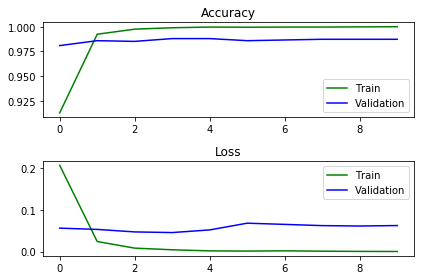

In [28]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluation

마지막으로 실제 평가 결과를 확인하고, test 데이터의 첫 다섯 개 문장을 모델이 어떻게 분류하였는지 살펴보도록 하겠습니다. 

In [33]:
score, acc = model.evaluate(X_test, y_test, batch_size = batch_size)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

for i in range(5):
    idx = np.random.randint(len(X_test))
    xtest = X_test[idx].reshape(1,40)
    ylabel = y_test[idx]
    ypred = model.predict(xtest)[0][0]
    sent = " ".join([idx2word[x] for x in xtest[0].tolist() if x != 0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

1418/1418 [==============================] - 1s 549us/step
Test score: 0.062, accuracy: 0.987
1	1	i love the da vinci code ...
1	1	love luv lubb the da vinci code !
0	0	harry potter dragged draco malfoy s trousers down past his hips and sucked him into his throat with vigor , making whimpering noises and panting and groaning around the blonds rock-hard , aching cock ...
1	1	and , i mean , i love brokeback mountain .
1	1	* i like harry potter..


**Note:** 나중에 `LSTM`을 이용한 문장 분류나 감성 분석을 실시할 때, 단어별로 문장에 대한 `prediction`이 어떻게 변화하는지 살펴볼 수 있는 방법도 있습니다. 시간이 있으면 간단하게 결과를 소개하도록 하겠습니다. 